In [1]:
import pandas as pd
import numpy as np
import math
import xlsxwriter
from pathlib import Path
from matplotlib import pyplot as plt
from scipy import signal

### Step 1 : Load multiple excel files (Set initial value & CV/GV Dataframe)

In [2]:
class initVal: # Store initial Value from multiple excels
    def __init__(self):
        self._Freq = []
        self._W = []
        self._V = []
        self._Area = 1 * 1e-3

class pdGroups:
    def __init__(self):
        self.G1 = pd.DataFrame() # used to store CV DataFrame
        self.G2 = pd.DataFrame() # used to store GV DataFrame

global init
global dfGroups        
         
excelPaths = ['./Requirements/MFCV-1  Light #1-2_light.csv',
              './Requirements/MFCV-2  Light #1-2_light.csv', 
              './Requirements/MFCV-3  Light #1-2_light.csv', 
              './Requirements/MFCV-4  Light #1-2_light.csv']

# Multiple dataframes
dfs = []
global init
init = initVal()
for i in range(len(excelPaths)):
    dfs.append("df" + str(i))
    dfs[i] = pd.DataFrame()
    dfs[i] = pd.read_csv(excelPaths[i], encoding='utf-8', sep='\t')
    dfs[i] = dfs[i].iloc[:, 0].str.split(',', expand=True)

    # auto retrieve VBias (if dataset change)
    a = dfs[i].iloc[:, 0].str.strip().tolist()
    indexes = [index for index in range(len(a)) if a[index] == 'DataName']
    if len(indexes) == 0:
        indexes = [index for index in range(len(a)) if a[index] == 'VBias']
        if len(indexes) == 0:
            a = dfs[i].iloc[:, 1].str.strip().tolist()
            indexes = [index for index in range(len(a)) if a[index] == 'VBias']
            dfs[i] = dfs[i].iloc[:, 1:][indexes[0]:].dropna(axis=1)
        else:
            dfs[i] = dfs[i].iloc[:, 0:][indexes[0]:].dropna(axis=1)
    else:
        dfs[i] = dfs[i].iloc[:, 1:][indexes[0]:].dropna(axis=1)
    dfs[i] = dfs[i].rename(columns=dfs[i].iloc[0]).drop(dfs[i].index[0]).reset_index(drop=True)
    dfs[i].columns = dfs[i].columns.str.strip()  # To strip whitespaces
    dfs[i] = dfs[i].loc[:, ["VBias", "Freq", "C", "G"]].apply(pd.to_numeric, 1)

    # Definite Value (_Freq, _V, _Area)
    init._Freq += sorted(list(set(dfs[i]["Freq"].tolist())))
    init._V = dfs[0].query("Freq == @init._Freq[0]")[
        "VBias"].tolist()  # all V
    init._Area = 1 * 1e-3
    

#  Get CV and GV Dataframe
global dfGroups
dfGroups = pdGroups()
dfGroups.G1 = pd.DataFrame(columns=init._Freq)  # C
dfGroups.G2 = pd.DataFrame(columns=init._Freq)  # G
for i in range(len(init._Freq)):
    init._W.append(2 * (math.pi) * init._Freq[i])  # Definite Value (_W = 2*pi*_Freq)
    listC = []
    listG = []
    for j in range(len(excelPaths)):
        listC += dfs[j].query("Freq == @init._Freq[@i]")["C"].tolist()
        listG += dfs[j].query("Freq == @init._Freq[@i]")["G"].tolist()

    dfGroups.G1[init._Freq[i]] = listC #CV DataFrame
    dfGroups.G2[init._Freq[i]] = listG #GV DataFrame

# Print DataFrame example 
# print(dfGroups.G1)    

### Step2 : Set Volt range

In [3]:
# 0. Update "_V" by windows Form (customized Value)

def indices(lst, item): 
    return [i for i, x in enumerate(lst) if x == item]

# Duplicates element & Get minimum
v_start = indices(init._V, float(init._V[0])) # init._V[0] : First _Volt
v_end = indices(init._V, float(init._V[-1])) # init._V[-1] : last _Volt
if ((float(init._V[0]) < 0) and (float(init._V[-1]) > 0)):  # -5 ~ 5
    min_V1 = min(v_start)
    min_V2 = min(v_end)
else:  # equal or v1 > v2 ..
    min_V1 = min(v_start)
    min_V2 = max(v_end)

# Update _V & dfGroups
init._V = np.array(init._V)[min_V1: (min_V2+1)].tolist() # init._V (range) # e.g. -5 ~ 5
dfGroups.G1 = pd.DataFrame(dfGroups.G1.to_numpy()[min_V1: (min_V2+1)]) # CV DataFrame
dfGroups.G2 = pd.DataFrame(dfGroups.G2.to_numpy()[min_V1: (min_V2+1)]) # GV DataFrame


In [4]:
# ################################# Goodness of Fit (R^2)######################################
def __sst(y_no_fitting):
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_no_fitting]
    sst = sum(s_list)
    return sst

def __ssr(y_fitting, y_no_fitting):
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_fitting]
    ssr = sum(s_list)
    return ssr

def __sse(y_fitting, y_no_fitting):
    s_list = [(y_fitting[i] - y_no_fitting[i])**2 for i in range(len(y_fitting))]
    sse = sum(s_list)
    return sse

def goodness_of_fit(y_fitting, y_no_fitting):
    SSR = __ssr(y_fitting, y_no_fitting)
    SST = __sst(y_no_fitting)
    SSE = __sse(y_fitting, y_no_fitting)   
    r2 = 1 - (SSE / SST)
    if(r2 < 0 or r2 > 1) :
        r2 = SSR / SST    
        if(r2 < 0 or r2 > 1) :
            r2 = -1
    return r2
# ########################################################################################### #


# ##################### Get Peak(x) & Peak(y) From original Gp/ #########################
"""
計算原始資料(GP_W)峰值的X和Y座標 
:param i: 目前的Volt值
:return: 原始實驗數據Ori_Gp/W資料表(df),峰值X(τ), 峰值y(D)
"""
def Get_τ_and_D(i):   
    """ Start calculate original GP/ω"""
    Gp_W = []
    for j in range(len(init._Freq)):
        Cm = dfGroups.G1.iat[i, j] / init._Area # Get Cm from G1(CV dataframe)
        Gm = dfGroups.G2.iat[i, j] / init._Area # Get Gm from G2(GV dataframe)
        Cox = (dfGroups.G1.iloc[:, j].max()) / init._Area
        # Calulate original GP_W
        Gp_W.append((init._W[j] * math.pow(Cox, 2) * Gm)/(math.pow(Gm, 2) + (math.pow(init._W[j], 2) * math.pow(Cm - Cox, 2))))

    df.insert(len(df.columns), str(init._V[i]), Gp_W, True)    # store to dataframe (GP/W)

    xx = np.array(df["W"]) # X-Axis
    yy = np.array(df.iloc[:, 1])   # Y-Axis
    q = 1.60 * 1e-19

    τ = (1 / xx[np.argmax(yy)]) # Peak(X) : xx[np.argmax(yy)] 
    D = (yy[np.argmax(yy)] * 2 / q) # Peak(Y) : yy[np.argmax(yy)]
    
    return τ, D
# ########################################################################################### #

# ##################### Adjuest (Shift Dit) #########################
"""
    Adjust函數: 調整理論公式下的Dit
    :param df: 原始實驗數據Ori_Gp/W的資料表(dataframe)
    :param i: 目前的Volt值
    :param D_val: Dit的位移量
    :return: 位移後的理論數據Gp/W資料表(dfTH_NEW), 峰值X(τit_NEW), 峰值y(Dit_NEW)
"""
def Adjust( i, D_val):    
    """ Start calculate Theoretical GP/ω (with shift value) """
    xx = np.array(df["W"]) # X-Axis(_Freq)
    yy = np.array(df.iloc[:, 1]) # Y-Axis (Gp/W)
    q = 1.60 * 1e-19

    τit = (1 / xx[np.argmax(yy)]) 
    Dit = (yy[np.argmax(yy)] * 2 / q) - D_val # Shift value

    Theoretical_Gp_W = []
    for j in range(len(init._Freq)):
        w = init._W[j]
        Theoretical_Gp_W.append((q * w * τit * Dit) / (1 + (math.pow(w * τit, 2)))) 

    dfTH.insert(len(dfTH.columns), str(init._V[i]), Theoretical_Gp_W, True)
    
    return dfTH, τit, Dit
# ########################################################################################### #

""" 開始計算每一個Volt對應最佳Fit值"""
for i in range(3): 
#for i in range(len(init._V)): # range(Volt numbers) e.g. From -5 to 5 #    
    """ 初始資料表設定 : Set dataframe(dfTH) """
    _each_W = []
    for j in range(len(init._Freq)):
        _each_W.append(float(init._W[j]))

    results = {
        "W": sorted(_each_W),
    } 
    df = pd.DataFrame(results) # df used to store original GP/ω data
    dfTH = pd.DataFrame(results) # df used to store theoretical GP/ω data
    dfTH_NEW = pd.DataFrame(results) # df used to store shift theoretical GP/ω data
    init._W = sorted(init._W)
        
    """ 步驟1: 先計算原始資料(GP_W)峰值的X和Y座標  """
    τ, D =  Get_τ_and_D(i) # Get Peak From original GP_W 
    
    """ 設定邊界 """
    minD = D / 10
    maxD = D * 10
    
    """ 存放計算好的Gp_W數值(即原始實驗數據) """
    b = np.array(df.iloc[:, 1])    # Original_Gp_W  

    """ 初始參數值=0 """ 
    tmp1 = 0
    rr1 = 0
    maxI = 0
    maxJ = 0
    
    for j in np.arange(0, minD, ((maxD-minD)/ 1e+5)):   
        """ 步驟2: 調整理論公式下的Dit  """
        dfTH_NEW, τit_NEW, Dit_NEW = Adjust(i, j) # j: D_Val (shift value)
        a = np.array(dfTH_NEW.iloc[:, 1])  # Theoretical_Gp_W  (After Shift)
        
        """ 步驟3: 調整後，計算擬和度 -> 新的理論數值TH_Gp/W(a)跟原始實驗數據Ori_Gp/W(b) """
        tmp1 = goodness_of_fit(a, b)    
        
        """ 步驟4: 根據每一次的調整，去取得最大擬和度的τit及Dit """
        if(tmp1 > rr1): 
            maxτ = τit_NEW 
            maxD = Dit_NEW
            rr1 = max(tmp1, rr1)
             
    print("(V = " + str(init._V[i]) + ")" + " Best fit:" , rr1) 
    print("maxτ:", maxτ) 
    print("maxD:", maxD) 


(V = -10.0) Best fit: 0.9506073953734436
maxτ: 3.7735025858156584e-07
maxD: 7525664246935.218
(V = -9.8) Best fit: 0.9501074412600297
maxτ: 3.7735025858156584e-07
maxD: 7553116191001.926
(V = -9.6) Best fit: 0.9499750864499835
maxτ: 3.7735025858156584e-07
maxD: 7579989767397.787


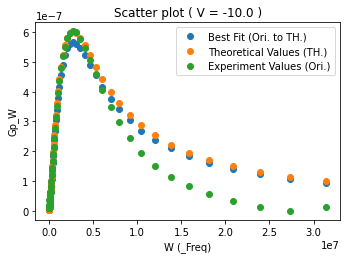

In [5]:
# Draw Example

# 0. Update "_V" by windows Form (customized Value)
# Duplicates element & Get minimum
v_start = indices(init._V, float(init._V[0]))
v_end = indices(init._V, float(init._V[-1]))
if ((float(init._V[0]) < 0) and (float(init._V[-1]) > 0)):  # -5 ~ 5
    min_V1 = min(v_start)
    min_V2 = min(v_end)
else:  # equal or v1 > v2 ..
    min_V1 = min(v_start)
    min_V2 = max(v_end)

# update _V & dfGroups
init._V = np.array(init._V)[min_V1: (min_V2+1)].tolist()
dfGroups.G1 = pd.DataFrame(dfGroups.G1.to_numpy()[min_V1: (min_V2+1)])
dfGroups.G2 = pd.DataFrame(dfGroups.G2.to_numpy()[min_V1: (min_V2+1)])

_each_W = []
for j in range(len(init._Freq)):
    _each_W.append(float(init._W[j]))

results = {
    "W": sorted(_each_W),
}
df = pd.DataFrame(results)
df_ori = pd.DataFrame(results)
dfTH = pd.DataFrame(results)
dfTH_Best = pd.DataFrame(results)
init._W = sorted(init._W)

for i in range(1): #len(init._V)
    Gp_W = []
    for j in range(len(init._Freq)):
        Cm = dfGroups.G1.iat[i, j] / init._Area
        Gm = dfGroups.G2.iat[i, j] / init._Area
        Cox = (dfGroups.G1.iloc[:, j].max()) / init._Area

        Gp_W.append((init._W[j] * math.pow(Cox, 2) * Gm)/(math.pow(Gm, 2) + (math.pow(init._W[j], 2) * math.pow(Cm - Cox, 2))))

    df.insert(len(df.columns), str(init._V[i]), Gp_W, True)    

    xx = np.array(df["W"]) 
    yy = np.array(df.iloc[:, i+1])  
    q = 1.60 * 1e-19

    τit = (1 / xx[np.argmax(yy)]) 
    Dit = (yy[np.argmax(yy)] * 2 / q) 
    
    Theoretical_Gp_W = []
    for j in range(len(init._Freq)):
        w = init._W[j]
        Theoretical_Gp_W.append((q * w * τit * Dit) / (1 + (math.pow(w * τit, 2))))

    τit = 3.7735025858156584e-07  # maxτ
    Dit = 7075659627625.4795
    dfTH.insert(len(dfTH.columns), str(init._V[i]), Theoretical_Gp_W, True)
    
    Theoretical_Gp_W_NEW = []
    for j in range(len(init._Freq)):
        w = init._W[j]
        Theoretical_Gp_W_NEW.append((q * w * τit * Dit) / (1 + (math.pow(w * τit, 2))))
        
    dfTH_Best.insert(len(dfTH_Best.columns), str(init._V[i]), Theoretical_Gp_W_NEW, True)

fig = plt.figure(figsize=(12, 8))  
# Scatter plot (Print one Volt = -15V)
x1 = np.array(df["W"])        
y1 = np.array(dfTH_Best.iloc[:, 1])  
y2 = np.array(dfTH.iloc[:, 1])  
y3 = np.array(df.iloc[:, 1])  
plt.subplot(222)
plt.plot(x1, y1, 'o', label='Best Fit (Ori. to TH.)') 
plt.plot(x1, y2, 'o', label='Theoretical Values (TH.) ') 
plt.plot(x1, y3, 'o', label='Experiment Values (Ori.)') 
plt.legend(loc=1)

plt.title(f'Scatter plot ( V = ' + str(init._V[0]) + ' )' )
plt.ylabel("Gp_W") # y label
plt.xlabel("W (_Freq)") # x label

plt.show()